<a href="https://colab.research.google.com/github/Kabindra02/Flood_Severity_index/blob/main/Flood_Severity_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('/content/Final_data_set - Sheet1.csv')
df.shape


(5478, 13)

In [6]:
df.head()

,Date,Daily flow Rate,Gauge height flow,NDVI,Latitude,Longitude,sm_top_0_10cm,sm_10_40cm,Latitude.1,Longitude.1,24h accumulated,Daily Max,Daily Min
0,2009-01-01,470,3.36,0.7687,NaN,81.2981,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2009-01-02,460,3.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2009-01-03,456,3.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2009-01-04,448,3.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2009-01-05,445,3.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [4]:
df.columns.tolist()

['Date',
 'Daily flow Rate',
 'Gauge height flow',
 'NDVI',
 'Latitude',
 'Longitude',
 'sm_top_0_10cm',
 'sm_10_40cm',
 'Latitude.1',
 'Longitude.1',
 '24h accumulated',
 'Daily Max',
 'Daily Min']

In [5]:
date_col = None
for c in ['Date', 'date', 'Datetime', 'datetime', 'TIME', 'time']:
    if c in df.columns:
        date_col = c
        break

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)
    print(f"\nDetected date column: {date_col} (converted to datetime)")
else:
    print("\nNo explicit date column detected; proceeding with index-order as time series.")


Detected date column: Date (converted to datetime)


In [7]:
#only required columns
cols = ['Daily flow Rate', 'Gauge height flow', '24h accumulated', 'sm_top_0_10cm', 'sm_10_40cm']
missing_cols = [c for c in cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"The following required columns are missing from the CSV: {missing_cols}")

In [8]:
# Create df_proc and set datetime index if available
df_proc = df[cols].copy()
if date_col:
    df_proc.index = df[date_col]

In [9]:
# Missing value summary
missing_summary = df_proc.isna().mean().sort_values(ascending=False)
print("\nMissing fractions per column:\n", missing_summary)


Missing fractions per column:
 24h accumulated      0.283863
sm_10_40cm           0.066630
sm_top_0_10cm        0.066630
Daily flow Rate      0.000000
Gauge height flow    0.000000
dtype: float64


28% value missing in 24h accumulated, 6% values missing in both sm_10 and 40, and 0% missing in flow rate and gauge height


In [11]:
# Check if the df has a datetime-based index
time_based = isinstance(df_proc.index, pd.DatetimeIndex)

#columns to interpolate
to_interpolate = ['Daily flow Rate', 'Gauge height flow', '24h accumulated']

for col in to_interpolate:
    if time_based:
        df_proc[col] = df_proc[col].interpolate(method='time')
    else:
        df_proc[col] = df_proc[col].interpolate(method='linear')

    # forward/backward fill any edge missings
    # After interpolation, fill any remaining missing values at the edges:
    # - ffill: propagates last known value forward
    # - bfill: propagates next known value backward

    df_proc[col] = df_proc[col].fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-2608455876.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_proc[col] = df_proc[col].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2608455876.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_proc[col] = df_proc[col].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2608455876.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_proc[col] = df_proc[col].fillna(method='ffill').fillna(method='bfill')


In [13]:
# Define soil moisture columns (these are the target columns to impute)
soil_cols = ['sm_top_0_10cm', 'sm_10_40cm']

# Combining soil columns with other related features likely to help with imputation
knn_features = soil_cols + ['Daily flow Rate', 'Gauge height flow', '24h accumulated']

# Applying KNN imputation to fill missing values in selected features
imputer = KNNImputer(n_neighbors=3)
df_proc[knn_features] = imputer.fit_transform(df_proc[knn_features])

# if other columns still missing, fallback to IterativeImputer
if df_proc.isna().any().any():
    it_imp = IterativeImputer(random_state=0, max_iter=10)
    df_proc[df_proc.columns] = it_imp.fit_transform(df_proc[df_proc.columns])

print("\nAfter imputation, any missing?", df_proc.isna().any().any())



After imputation, any missing? False


# Feature Engineering


In [15]:
#capturing short and medium term rainfall accumualation over the past 3 and 7 days
df_proc['rain_3d'] = df_proc['24h accumulated'].rolling(window=3, min_periods=1).sum()
df_proc['rain_7d'] = df_proc['24h accumulated'].rolling(window=7, min_periods=1).sum()

#calculating mean of daily flow rate over past 3 and 7 days
df_proc['flow_3d_mean'] = df_proc['Daily flow Rate'].rolling(window=3, min_periods=1).mean()
df_proc['flow_7d_mean'] = df_proc['Daily flow Rate'].rolling(window=7, min_periods=1).mean()

#for capturing sudden spikes or changes in flow rate or gauge height
df_proc['flow_diff_1d'] = df_proc['Daily flow Rate'].diff().fillna(0)
df_proc['gauge_diff_1d'] = df_proc['Gauge height flow'].diff().fillna(0)

#average soil moisture across top and sub surface layers that provides soil wetness indicator
df_proc['soil_avg'] = df_proc[['sm_top_0_10cm', 'sm_10_40cm']].mean(axis=1)

# Antecedent Precipitation Index (API) - simple recursive formula
# API_today = k * API_yesterday + Rain_today
# Where k is a decay constant (e.g., 0.8) representing water retention

k = 0.8
api = np.zeros(len(df_proc))
for i in range(1, len(df_proc)):
    api[i] = k * api[i - 1] + df_proc['24h accumulated'].iloc[i]
df_proc['API'] = api

feature_cols = [
    'Daily flow Rate', 'Gauge height flow', '24h accumulated',
    'sm_top_0_10cm', 'sm_10_40cm', 'rain_3d', 'rain_7d',
    'flow_3d_mean', 'flow_7d_mean', 'flow_diff_1d', 'gauge_diff_1d', 'soil_avg', 'API'
]

print("\nFeature columns prepared:", feature_cols)
display(df_proc[feature_cols].head())


Feature columns prepared: ['Daily flow Rate', 'Gauge height flow', '24h accumulated', 'sm_top_0_10cm', 'sm_10_40cm', 'rain_3d', 'rain_7d', 'flow_3d_mean', 'flow_7d_mean', 'flow_diff_1d', 'gauge_diff_1d', 'soil_avg', 'API']


,Daily flow Rate,Gauge height flow,24h accumulated,sm_top_0_10cm,sm_10_40cm,rain_3d,rain_7d,flow_3d_mean,flow_7d_mean,flow_diff_1d,gauge_diff_1d,soil_avg,API
Date,,,,,,,,,,,,,
2009-01-01,470.0,3.36,0.0,20.222000,63.263360,0.0,0.0,470.000000,470.0,0.0,0.00,41.742680,0.0
2009-01-02,460.0,3.34,0.0,18.118000,54.073805,0.0,0.0,465.000000,465.0,-10.0,-0.02,36.095903,0.0
2009-01-03,456.0,3.33,0.0,22.784667,65.749364,0.0,0.0,462.000000,462.0,-4.0,-0.01,44.267015,0.0
2009-01-04,448.0,3.31,0.0,22.027667,68.656034,0.0,0.0,454.666667,458.5,-8.0,-0.02,45.341850,0.0
2009-01-05,445.0,3.30,0.0,18.637667,58.216001,0.0,0.0,449.666667,455.8,-3.0,-0.01,38.426834,0.0


# Scaling

In [16]:
# Step 1: Apply RobustScaler to reduce the influence of outliers
# It scales features using the median and IQR (interquartile range)
rs = RobustScaler()
scaled = rs.fit_transform(df_proc[feature_cols])

# Step 2: Applying MinMaxScaler to bring all values into the [0, 1] range
# This is useful for models sensitive to feature scale
mms = MinMaxScaler()
scaled = mms.fit_transform(scaled)

# Step 3: Wrap the scaled array back into a DataFrame with original feature names and index
df_scaled = pd.DataFrame(scaled, columns=feature_cols, index=df_proc.index)


#This two-step scaling process makes sure that no single feature (like 'Daily flow Rate', which has large values)
#can unfairly dominate the analysis. It puts all features on a level playing field.

In [17]:
# Combine two key scaled signals with weights to create a composite indicator
combined_signal = 0.6 * df_scaled['Gauge height flow'] + 0.4 * df_scaled['Daily flow Rate']

# Calculate percentile thresholds for defining label boundaries
p1 = np.percentile(combined_signal, 75)    # 75th percentile
p2 = np.percentile(combined_signal, 90)    # 90th percentile
p3 = np.percentile(combined_signal, 97.5)  # 97.5th percentile

# Define function to assign proxy labels based on where the value falls relative to thresholds
def proxy_label(x):
    if x <= p1:
        return 0   # Low
    elif x <= p2:
        return 1   # Moderate
    elif x <= p3:
        return 2   # High
    else:
        return 3   # Very high/extreme

# Apply the labeling function element-wise to the combined signal
proxy_labels = combined_signal.apply(proxy_label)

# Display the count of each proxy label to understand the class distribution
print("\nProxy label distribution:\n", proxy_labels.value_counts().sort_index())




Proxy label distribution:
 0    4108
1     822
2     411
3     137
Name: count, dtype: int64


In [18]:
# Copy scaled features to X (predictors) and extract proxy labels to y (target)
X = df_scaled.copy()
y = proxy_labels.values

# Check that at least two classes exist in the target labels
# Random Forest requires at least 2 classes to train properly
unique_counts = np.bincount(y)
nonzero_classes = np.where(unique_counts > 0)[0].tolist()
if len(nonzero_classes) < 2:
    raise ValueError("Proxy labels do not contain at least 2 classes - cannot train RF. Adjust thresholds.")

# Split data into training and test sets (75% train, 25% test)
# Stratify to maintain class proportions in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Initialize Random Forest classifier with 200 trees and fixed random seed
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the model on the training data
rf.fit(X_train, y_train)

# Predict proxy labels on the test set
y_pred = rf.predict(X_test)

# Print a detailed classification report (precision, recall, F1-score, support)
print("\nClassification report (RF predicting proxy labels):")
print(classification_report(y_test, y_pred))

# Calculate and display feature importances from the trained Random Forest
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nFeature importances (descending):\n", importances)

# Normalize feature importances so they sum to 1
weights = (importances / importances.sum()).reindex(feature_cols).fillna(0)
print("\nNormalized weights for Flood Index:\n", weights)



Classification report (RF predicting proxy labels):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1027
           1       0.99      1.00      1.00       206
           2       1.00      0.99      1.00       103
           3       1.00      1.00      1.00        34

    accuracy                           1.00      1370
   macro avg       1.00      1.00      1.00      1370
weighted avg       1.00      1.00      1.00      1370


Feature importances (descending):
 Gauge height flow    0.311518
Daily flow Rate      0.278977
flow_3d_mean         0.197880
flow_7d_mean         0.113145
soil_avg             0.025584
sm_10_40cm           0.020216
sm_top_0_10cm        0.018491
flow_diff_1d         0.016853
gauge_diff_1d        0.011544
API                  0.003189
rain_7d              0.001606
rain_3d              0.000609
24h accumulated      0.000387
dtype: float64

Normalized weights for Flood Index:
 Daily flow Rate      0.278977
Gau

In [25]:
# Compute Flood Index as weighted sum of scaled features
# Each feature is multiplied by its normalized importance weight
df_scaled['Flood_Index'] = (df_scaled[feature_cols] * weights).sum(axis=1)

# --- REVISED BINNING STRATEGY ---
# Map the Flood_Index into severity classes using the same percentile thresholds
# used for the proxy labels (75th, 90th, 97.5th). This creates a more
# realistic, imbalanced distribution where "No Flood" is the most common class.

# Calculate the percentile values for the Flood_Index
idx_p1 = np.percentile(df_scaled['Flood_Index'], 75)
idx_p2 = np.percentile(df_scaled['Flood_Index'], 90)
idx_p3 = np.percentile(df_scaled['Flood_Index'], 97.5)

# Define the bin edges using these percentiles.
# -np.inf and np.inf ensure that all values are included.
bins = [-np.inf, idx_p1, idx_p2, idx_p3, np.inf]
labels = [0, 1, 2, 3]

# Create the final 'Severity' column using the new percentile-based bins
df_scaled['Severity'] = pd.cut(df_scaled['Flood_Index'], bins=bins, labels=labels, include_lowest=True)



In [26]:
# Create a result DataFrame with Flood Index and Severity
df_result = df_scaled[['Flood_Index', 'Severity']].copy()

# Add the original proxy labels for comparison
df_result['Proxy_Label'] = proxy_labels.values

# Convert Severity from categorical to integer for evaluation
df_result['Severity_int'] = df_result['Severity'].astype(int)

# Print confusion matrix comparing computed Severity classes to proxy labels
print("\nConfusion matrix between computed Severity and proxy labels:")
print(confusion_matrix(df_result['Proxy_Label'], df_result['Severity_int']))

# Print classification report comparing computed Severity to proxy labels
# Shows precision, recall, f1-score for each class
print("\nClassification report comparing computed Severity to proxy labels:")
print(classification_report(df_result['Proxy_Label'], df_result['Severity_int']))

# Prepare final output table for inspection or export
# Include Date column if it was detected and set earlier
if date_col:
    # Reset index to bring the date index as a column
    out = df_proc[feature_cols].reset_index().rename(columns={'index': date_col})
    # Concatenate Flood Index and Severity columns
    out = pd.concat([out, df_scaled[['Flood_Index', 'Severity']].reset_index(drop=True)], axis=1)
else:
    # If no date column, just combine features and results side-by-side
    out = pd.concat([df_proc[feature_cols].reset_index(drop=True), df_scaled[['Flood_Index', 'Severity']].reset_index(drop=True)], axis=1)

# Display the first 10 rows for quick inspection
display(out.head(10))



Confusion matrix between computed Severity and proxy labels:
[[4080   28    0    0]
 [  28  754   39    1]
 [   0   40  347   24]
 [   0    0   25  112]]

Classification report comparing computed Severity to proxy labels:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4108
           1       0.92      0.92      0.92       822
           2       0.84      0.84      0.84       411
           3       0.82      0.82      0.82       137

    accuracy                           0.97      5478
   macro avg       0.89      0.89      0.89      5478
weighted avg       0.97      0.97      0.97      5478



,Date,Daily flow Rate,Gauge height flow,24h accumulated,sm_top_0_10cm,sm_10_40cm,rain_3d,rain_7d,flow_3d_mean,flow_7d_mean,flow_diff_1d,gauge_diff_1d,soil_avg,API,Flood_Index,Severity
0,2009-01-01,470.0,3.36,0.0,20.222000,63.263360,0.0,0.0,470.000000,470.000000,0.0,0.00,41.742680,0.0,0.117511,0
1,2009-01-02,460.0,3.34,0.0,18.118000,54.073805,0.0,0.0,465.000000,465.000000,-10.0,-0.02,36.095903,0.0,0.111320,0
2,2009-01-03,456.0,3.33,0.0,22.784667,65.749364,0.0,0.0,462.000000,462.000000,-4.0,-0.01,44.267015,0.0,0.119269,0
3,2009-01-04,448.0,3.31,0.0,22.027667,68.656034,0.0,0.0,454.666667,458.500000,-8.0,-0.02,45.341850,0.0,0.119062,0
4,2009-01-05,445.0,3.30,0.0,18.637667,58.216001,0.0,0.0,449.666667,455.800000,-3.0,-0.01,38.426834,0.0,0.111800,0
5,2009-01-06,449.0,3.31,0.0,17.945667,56.251036,0.0,0.0,447.333333,454.666667,4.0,0.01,37.098351,0.0,0.110729,0
6,2009-01-07,453.0,3.32,0.0,18.687000,58.913774,0.0,0.0,449.000000,454.428571,4.0,0.01,38.800387,0.0,0.112707,0
7,2009-01-08,449.0,3.31,0.0,17.945667,56.251036,0.0,0.0,450.333333,451.428571,-4.0,-0.01,37.098351,0.0,0.110706,0
8,2009-01-09,441.0,3.29,0.0,17.719000,53.985001,0.0,0.0,447.666667,448.714286,-8.0,-0.02,35.852000,0.0,0.108905,0
9,2009-01-10,433.0,3.27,0.0,19.164333,60.726332,0.0,0.0,441.000000,445.428571,-8.0,-0.02,39.945333,0.0,0.111982,0


In [21]:
out_file = 'Flood_Severity_Output.csv'
out.to_csv(out_file, index=False)
print(f"Saved to current directory as: {out_file}")


Saved to current directory as: Flood_Severity_Output.csv


In [27]:
# Path to your target folder in Google Drive
output_dir = '/content/drive/My Drive/FloodAnalysis'

# Create folder if it doesn't exist
import os
os.makedirs(output_dir, exist_ok=True)

# Save the output CSV to that folder
out_file = os.path.join(output_dir, 'Flood_Severity_Output1.csv')
out.to_csv(out_file, index=False)

print(f"✅ Saved Flood Severity output to: {out_file}")


✅ Saved Flood Severity output to: /content/drive/My Drive/FloodAnalysis/Flood_Severity_Output1.csv


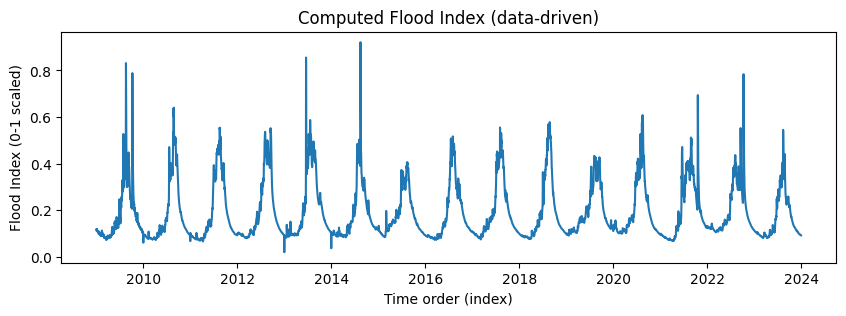

In [29]:
plt.figure(figsize=(10,3))
plt.plot(df_scaled['Flood_Index'])
plt.title('Computed Flood Index (data-driven)')
plt.xlabel('Time order (index)')
plt.ylabel('Flood Index (0-1 scaled)')
plt.show()